<a href="https://colab.research.google.com/github/kollerbud/btc_project/blob/main/src/notebooks/Project6242.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.10.12


# Data Loading Pipeline

In [2]:
import pandas as pd
from typing import Any, Tuple, Dict, List
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as stat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
class Data_Loader:

  data = None

  def __init__(self) -> None:
    self.load_data()

  def load_data(self) -> 'Data_Loader':
    # read from github
    df_data = pd.read_csv('https://raw.githubusercontent.com/kollerbud/btc_project/main/data/Data_ex_FRED.csv', parse_dates=['Time'])
    df_fred = pd.read_csv('https://raw.githubusercontent.com/kollerbud/btc_project/main/data/FRED_HARDCODED2.csv', parse_dates=['DATE'])
    # drop Unnamed columns
    df_fred.drop(df_fred.filter(regex='Unname'), axis=1, inplace=True)
    df_data.drop(df_data.filter(regex='Unname'), axis=1, inplace=True)
    # join both dataframe
    df_combine = pd.merge(left=df_fred,
                          right=df_data,
                          how='inner',
                          left_on=['DATE'],
                          right_on=['Time'])
    # delete extra time
    del df_combine['Time']
    # drop null rows in "crypto_market"
    df_combine.dropna(subset=['crypto_market'], inplace=True)
    # remove columns with "..", "Country", "Country Code" etc..
    obj_col = df_combine.select_dtypes(include=['object']).columns
    df_combine = df_combine.loc[:, ~(df_combine.columns.isin(obj_col))]

    df_combine = df_combine.reset_index(drop=True).set_index('DATE')

    # initialize dataset
    self.data = df_combine

    return self

In [4]:
class Data_Processing:

  # keep track of dataset
  processed_data = None

  def __init__(self,
               data_loader: pd.DataFrame,
               target_col: list,
               keep_col: list = None,
               price_to_return: bool = False
               ) -> None:

    self.target_col = target_col
    if not isinstance(self.target_col, list):
      raise TypeError('use format "[column_name]"')
    # hook for data loader
    self.processed_data = data_loader.data
    # fill NAs
    self.clean_na(self.target_col)
    # remove columns with constant
    self.remove_const()
    # remove correlation
    if keep_col is not None:
      self.remove_correlation(
            target_col=self.target_col,
            include_col_list=keep_col)
    else:
      self.remove_correlation(target_col=self.target_col)
    # if convert to return instead
    if price_to_return:
      self.convert_to_return()

  def clean_na(self, target_var_list: list) -> 'Data_Processing':
    df_copy = self.processed_data.copy()
    # remove target column(s)
    df_copy = df_copy.loc[:, ~df_copy.columns.isin(target_var_list)]
    # find column of "object" datatype
    obj_col = df_copy.select_dtypes(include=['object']).columns
    for col in obj_col:
      try:
        df_copy[col] = df_copy[col].astype(float)
      except TypeError:
        df_copy[col] = df_copy[col].replace({'null':np.nan})
        df_copy[col] = df_copy[col].astype(float)
      except ValueError:
        df_copy[col] = df_copy[col].replace({'null':np.nan})
        df_copy[col] = df_copy[col].astype(float)

    # add target back in
    df_copy[target_var_list] = self.processed_data[target_var_list]
    # fill NAs
    df_copy = df_copy.fillna(method='ffill')

    # update dataset
    self.processed_data = df_copy

    return self

  def remove_const(self) -> 'Data_Processing':
    # there are columns with constant
    df_copy = self.processed_data.copy()

    exchange_col = [col for col in df_copy.columns if 'exchange rate' in col.lower()]

    df_copy = df_copy.loc[:, ~df_copy.columns.isin(exchange_col)]

    # reassign dataset
    self.processed_data = df_copy
    return self

  def remove_correlation(self,
                        target_col: list,
                        include_col_list: list=None,
                        cut_off: int=0.5) -> 'Data_Processing':
    # https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
    # https://www.kaggle.com/code/oldwine357/removing-highly-correlated-features
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/
    # .30 to .50 (−.30 to −.50)	Low positive (negative) correlation
    # .00 to .30 (.00 to −.30)	negligible correlation
    df_copy = self.processed_data.copy()
    # remove target column(s)
    df_copy = df_copy.loc[:, ~df_copy.columns.isin(target_col)]
    # create correlation matrix
    corr_matrix = df_copy.corr().abs()
    # select upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # find columns(features) with correlation higher than cut_off
    to_drop = [col for col in upper.columns if any(upper[col]>cut_off)]

    print(f'{len(to_drop)} columns dropped: {to_drop}')
    # drop the columns
    df_copy.drop(to_drop, axis=1, inplace=True)
    # add excluded list back in
    if include_col_list is not None:
      df_copy[include_col_list] = self.processed_data[include_col_list]
    # add target back in
    df_copy[target_col] = self.processed_data[target_col]

    # update dataset
    self.processed_data = df_copy

    return self

  def convert_to_return(self) -> 'Data_Processing':
    df_copy = self.processed_data.copy()
    # convert target to percent change from previous
    df_copy[self.target_col] = df_copy[self.target_col].pct_change(1)

    # first row is NA
    df_copy.dropna(subset=self.target_col, inplace=True)
    # update processing dataset
    self.processed_data = df_copy
    return self

In [5]:
class Data_Normalization:

  norm_data = None
  scaler_obj = {}

  def __init__(self,
               data_processor,
               use_scaler=StandardScaler()) -> None:
    # initialize dataset from processor above
    self.norm_data = data_processor.processed_data
    # initialize scaler
    self.scaler = use_scaler

  def normalize(self):
    df_copy = self.norm_data.copy()
    use_cols = df_copy.select_dtypes(exclude=['datetime']).columns
    df_copy = df_copy.loc[:, use_cols]

    for col in df_copy.columns:
      # loop through all columns and normalize data
      # reshape each column
      to_scale = np.array(df_copy[col]).reshape(-1,1)

      self.scaler_obj[col+'_scaler'] = self.scaler
      df_copy[col]=self.scaler.fit_transform(to_scale)

      # update norm_data
    self.norm_data = df_copy

    return self


In [6]:
class Data_Spliter:

  x_train = None
  y_train = None
  x_test = None
  y_test = None

  def __init__(self,
               norm_data: Data_Normalization,
               target_col: list):
    # initialize data from above
    self.norm_data = norm_data.norm_data

    self.target_col = target_col
    if not isinstance(self.target_col, list):
      raise TypeError('use format "[column_name]"')


  def data_splits(self,
                  train_perc: float=0.75,
                  valid_perc: float=0.10,
                  test_perc: float=0.15,
                  ) -> 'Data_Spliter':

    df_copy = self.norm_data.copy()

    _x = df_copy.loc[:, ~df_copy.columns.isin(self.target_col)]
    _y = df_copy.loc[:, self.target_col]
    # train is now 75% of the entire data set
    (self.x_train, self.x_test,
     self.y_train, self.y_test) = train_test_split(_x, _y, test_size=1 - train_perc, shuffle=False, random_state=24)
    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    # x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_perc/(test_perc + valid_perc), shuffle=False)

    return self

  def feature_selection_by_p(self,
                            p_val: float=0.05,
                            ):
    'select features by p-value'
    # initialize dataframe
    df_copy = self.norm_data.copy()
    # exlcude columns
    _target = df_copy.loc[:, self.target_col]
    _feature = df_copy.loc[:, ~df_copy.columns.isin(self.target_col)]

    # https://stackoverflow.com/questions/41075098/how-to-get-the-p-value-in-a-variable-from-olsresults-in-python
    ols_model = stat.OLS(_target, stat.add_constant(_feature)).fit()

    return ols_model

# Exploratory Data Analysis

# EDA Pipeline

In [7]:
def Preprocess_Pipeline():
  # load from data source
  loader = Data_Loader()
  # data type clean up and fill na
  _processor = Data_Processing(data_loader=loader,
                               target_col=['crypto_market'],
                               keep_col=['Crypto_Trends'],
                               price_to_return=True
                               )


  # normalize all columns
  normalization = Data_Normalization(data_processor=_processor)
  # normalization.normalize()
  # tracking scaler obj
  scaler_tracker = normalization.scaler_obj
  # train/test split
  split = Data_Spliter(norm_data=normalization, target_col=['crypto_market'])
  split.data_splits()

  y_train = split.y_train
  y_train = y_train.loc[y_train['crypto_market']!=0]
  x_train = split.x_train.loc[y_train.index]

  y_test = split.y_test
  y_test = y_test.loc[y_test['crypto_market']!=0]
  x_test  = split.x_test.loc[y_test.index]

  test_tot = pd.concat([y_train, y_test])
  inv_tot = (1 + test_tot).cumprod()*100

  return {
      'x_train': x_train,
      'x_test': x_test,
      'y_train': y_train,
      'y_test': y_test,
      'inverse_price': inv_tot
  }

In [8]:
prep = Preprocess_Pipeline()

<ipython-input-3-4f89dc4d9f56>:11: DtypeWarning: Columns (506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_fred = pd.read_csv('https://raw.githubusercontent.com/kollerbud/btc_project/main/data/FRED_HARDCODED2.csv', parse_dates=['DATE'])


504 columns dropped: ['D_AB1020AAVOL', 'D_AB14AAVOL', 'D_AB2140AAVOL', 'D_AB4180AAVOL', 'D_AB59AAVOL', 'D_ABGT80AAVOL', 'D_DEXCHUS', 'D_DEXDNUS', 'D_DEXINUS', 'D_DEXJPUS', 'D_DEXKOUS', 'D_DEXMAUS', 'D_DEXMXUS', 'D_DEXNOUS', 'D_DEXSDUS', 'D_DEXSFUS', 'D_DEXSIUS', 'D_DEXSLUS', 'D_DEXSZUS', 'D_DEXTAUS', 'D_DEXTHUS', 'D_DEXUSAL', 'D_DEXUSEU', 'D_DEXUSNZ', 'D_DEXUSUK', 'D_DEXVZUS', 'D_DTWEXAFEGS', 'D_DTWEXBGS', 'D_DTWEXEMEGS', 'D_FIN1020AAVOL', 'D_FIN14AAVOL', 'D_FIN2140AAVOL', 'D_FIN4180AAVOL', 'D_FIN59AAVOL', 'D_FINGT80AAVOL', 'D_MKT1020MKTAMT', 'D_MKT1020MKTVOL', 'D_MKT14MKTAMT', 'D_MKT14MKTVOL', 'D_MKT2140MKTAMT', 'D_MKT2140MKTVOL', 'D_MKT4180MKTVOL', 'D_MKT59MKTAMT', 'D_MKT59MKTVOL', 'D_MKTGT80MKTAMT', 'D_MKTGT80MKTVOL', 'D_NONFIN1020A2P2AMT', 'D_NONFIN1020A2P2VOL', 'D_NONFIN1020AAVOL', 'D_NONFIN14A2P2AMT', 'D_NONFIN14A2P2VOL', 'D_NONFIN14AAVOL', 'D_NONFIN2140A2P2AMT', 'D_NONFIN2140A2P2VOL', 'D_NONFIN2140AAVOL', 'D_NONFIN4180A2P2VOL', 'D_NONFIN4180AAVOL', 'D_NONFIN59A2P2AMT', 'D_NONFIN

In [9]:
# https://www.kaggle.com/code/ahammedjaleel/price-prediction-top-14-boosting-stacking

# Random Forest


In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, randint
import seaborn as sns
import joblib

In [11]:
# https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/
# https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#sphx-glr-auto-examples-compose-plot-transformed-target-py

_x_train = prep['x_train']
_y_train = prep['y_train']

y_test = prep['y_test']

In [12]:
# inverting percent change
inv_price = prep['inverse_price']
inv_price_train = inv_price.loc[_x_train.index]
inv_price_test = inv_price.loc[y_test.index]
# last price on x_train
last_train_price = inv_price.loc[_x_train.index[-1]]

In [13]:
# sns.distplot(_y_train, fit=norm)
# mu, sigma = norm.fit(_y_train)
# plt.ylabel('Frequency')
# plt.xlabel('Crypto Index Price')
# plt.title('Crypto Index Price Distribution')

In [24]:
class RFRegressor:

  def hyper_tuning(self, x_train, y_train):
    params = {
        'n_estimators': [75,85, 95, 105],
        'max_depth': [None, 100],
    }

    grid_search = GridSearchCV(
        estimator=RandomForestRegressor(random_state=123, n_jobs=-1),
        scoring='neg_mean_squared_error',
        param_grid=params,
        n_jobs=-1,
        return_train_score=True
    )

    rf_cv = grid_search.fit(x_train, y_train)

    return rf_cv.best_params_, rf_cv.best_score_


  def train_regressor(self, rf_reg, x_train, y_train):
    # {'max_depth': None, 'n_estimators': 85}, -0.002651902149024161
    rf_reg.fit(X=x_train, y=y_train)

    return rf_reg

In [58]:
rf = RandomForestRegressor(max_depth=None,
                           n_estimators=85,
                           random_state=123,
                           n_jobs=-1
                           )
# fit model
rf.fit(X=_x_train, y=_y_train)
# initialize test
_x_test = prep['x_test']
# prediction
pred = rf.predict(_x_test)
# inverse prediction to actual price
inv_pred = (1 + pred).cumprod()*last_train_price.values

root_score = np.sqrt(metrics.mean_squared_error(inv_pred, inv_price_test))

print(f'RMSE {root_score}')

<ipython-input-58-291416e63bb9>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X=_x_train, y=_y_train)


RMSE 538.2772278102482


In [17]:
importances = list(zip(rf.feature_importances_, _x_train.columns))
importances.sort(reverse=True)
print(importances)

[(0.058080088588635184, 'D_NONFIN14AAAMT'), (0.057354818566444074, 'Crypto_Trends'), (0.04973760722872525, 'D_AB2140AAAMT'), (0.04842490817706078, 'D_DEXCAUS'), (0.04764355824619975, 'D_ABGT80AAAMT'), (0.04294892935870635, 'D_NONFINGT80AAAMT'), (0.04142058514618848, 'D_NONFIN4180A2P2AMT'), (0.04136724803379409, 'D_NONFINGT80A2P2AMT'), (0.03851663430454275, 'D_AB14AAAMT'), (0.037617605313521534, 'D_FIN2140AAAMT'), (0.036525761027563095, 'D_DEXBZUS'), (0.036291808997839445, 'D_NONFIN1020AAAMT'), (0.03533909693312231, 'D_NONFIN4180AAAMT'), (0.03367113389131995, 'D_AB59AAAMT'), (0.03306443197652497, 'D_FIN59AAAMT'), (0.03276810256139959, 'D_AB4180AAAMT'), (0.03262087678517558, 'D_FINGT80AAAMT'), (0.0324325284304398, 'D_DEXHKUS'), (0.03119871691003026, 'D_NONFIN2140AAAMT'), (0.030608900272896387, 'D_AB1020AAAMT'), (0.030104847573444008, 'D_FIN14AAAMT'), (0.029385160725138682, 'D_NONFIN59AAAMT'), (0.028776512792090612, 'D_MKT4180MKTAMT'), (0.02092663194237616, 'D_FIN1020AAAMT'), (0.020363367

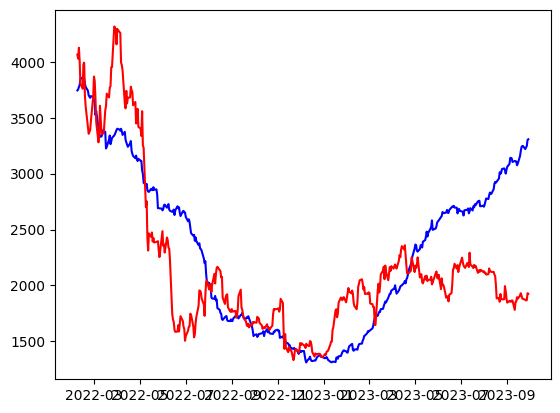

In [18]:
x_values = _x_test.index
plt.plot(x_values, inv_pred, label='pred', color='blue')
plt.plot(x_values, inv_price_test, label='actual', color='red')
plt.show()

# XGBOOST

In [19]:
from xgboost import XGBRegressor

In [29]:
class XgbRegression:

  def hyper_tuning(self, x_train, y_train):
    params = {
        "learning_rate": [0.05, 0.10],
        'n_estimators': [75,85, 95, 105],
        'max_depth': [None, 100],
    }

    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=123, n_jobs=-1),
        scoring='neg_mean_squared_error',
        param_grid=params,
        n_jobs=-1,
        return_train_score=True
    )

    rf_cv = grid_search.fit(x_train, y_train)

    return rf_cv.best_params_, rf_cv.best_score_


  def train_regressor(self):
    ...

In [30]:
XgbRegression().hyper_tuning(x_train=_x_train, y_train=_y_train)

({'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 75},
 -0.0026825579268249617)

In [53]:
xgb = XGBRegressor(learning_rate=0.05,
                   max_depth=None,
                   n_estimators=75,
                   n_jobs=-1,
                   random_state=123,
                  )

xgb.fit(X=_x_train, y=_y_train)

xgb_pred = xgb.predict(_x_test)

inv_xgb_pred =  (1 + xgb_pred).cumprod()*last_train_price.values

root_score = np.sqrt(metrics.mean_squared_error(inv_xgb_pred, inv_price_test))

print(f'RMSE {root_score}')

RMSE 585.8644468165759


In [54]:
importances = list(zip(xgb.feature_importances_, _x_train.columns))
importances.sort(reverse=True)
print(importances)

[(0.0707589, 'Q_LFAC55TTUSQ647N'), (0.050248746, 'D_NONFINGT80AAAMT'), (0.04705005, 'D_NONFIN14AAAMT'), (0.04354799, 'Crypto_Trends'), (0.043465547, 'D_NONFIN4180A2P2AMT'), (0.040273417, 'D_NONFINGT80A2P2AMT'), (0.03963018, 'D_DEXCAUS'), (0.038436588, 'D_DEXBZUS'), (0.037679747, 'D_DEXHKUS'), (0.03750527, 'D_MKT4180MKTAMT'), (0.03543561, 'D_FINGT80AAAMT'), (0.034640007, 'D_FIN2140AAAMT'), (0.03431885, 'D_ABGT80AAAMT'), (0.034177028, 'D_FIN14AAAMT'), (0.032841735, 'D_FIN59AAAMT'), (0.032711145, 'D_NONFIN4180AAAMT'), (0.03132973, 'D_NONFIN1020AAAMT'), (0.031306855, 'D_NONFIN2140AAAMT'), (0.030738235, 'D_FIN1020AAAMT'), (0.030709771, 'M_MARTSMPCSM44X72USN'), (0.029757794, 'M_CEU9000000001'), (0.02956947, 'D_AB59AAAMT'), (0.02909138, 'D_NONFIN59AAAMT'), (0.028571744, 'D_AB4180AAAMT'), (0.027247563, 'D_AB2140AAAMT'), (0.025989775, 'M_CEU0500000002'), (0.02419409, 'D_FIN4180AAAMT'), (0.018619899, 'D_AB14AAAMT'), (0.01015291, 'D_AB1020AAAMT'), (0.0, 'M_MYAGM2USM052N')]


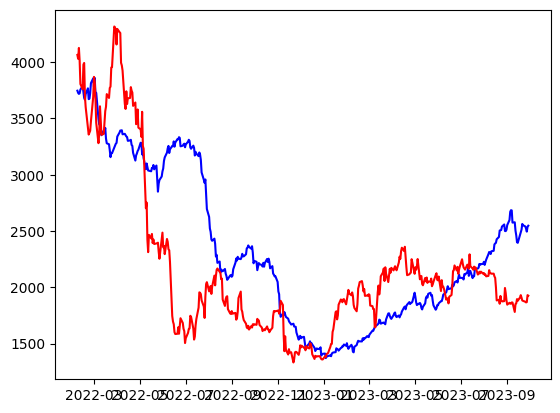

In [55]:
x_values = _x_test.index
plt.plot(x_values, inv_xgb_pred, label='pred', color='blue')
plt.plot(x_values, inv_price_test, label='actual', color='red')
plt.show()

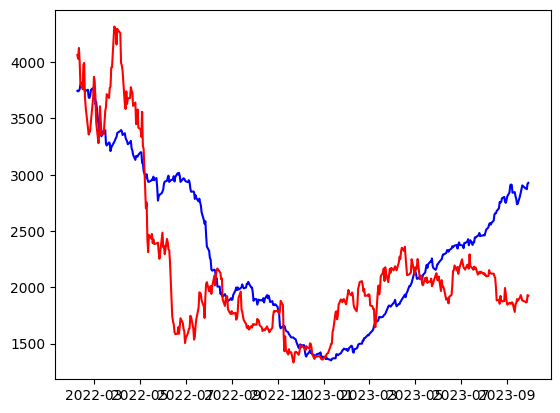

In [56]:
stack = np.mean([inv_pred, inv_xgb_pred], axis=0)

x_values = _x_test.index
plt.plot(x_values, stack, label='pred', color='blue')
plt.plot(x_values, inv_price_test, label='actual', color='red')
plt.show()

In [57]:
def Deploy_Pipeline(start, end):
  # load data from github
  df = Data_Loader().data
  # remove target
  df = df.loc[:, ~df.columns.isin(['crypto_market'])]
  # make extra columns
  # df[interaction_col] = df[col_1] * df[col_2]
  # ...

  # load trained model
  rand_forest = joblib.load('random_forest.pkl')

  # select range of date to test, used columns used in the model
  test = df.iloc[start:end][rand_forest.feature_names_in_]

  # make prediction
  prediction = rand_forest.predict(test)

  # any inversion required to get to actual price
  # (1 + prediction).cumprod()*last_train_price.values

  return prediction